<a href="https://colab.research.google.com/github/Enthusiastic-coder999/Command-Line-File-Reader/blob/main/Task1AIforAgriculture2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
import rasterio
import skimage.io as skio

In [2]:
import zipfile
import os

zip_file_path = 'beyond-visible-spectrum-ai-for-agriculture-2026.zip'
extract_dir = 'destination_folder'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted files to: {extract_dir}")

Extracted files to: destination_folder


The data had HS dim = 32x32

In [3]:
files=get_files('/content/destination_folder/Kaggle_Prepared/train/')
types=[]
for file in files:
    types.append(file.name.split('_')[0])

df=pd.DataFrame({'files':files,'types':types})
df.sample(10)

,files,types
579,/content/destination_folder/Kaggle_Prepared/train/MS/Rust_hyper_186.tif,Rust
788,/content/destination_folder/Kaggle_Prepared/train/HS/Other_hyper_192.tif,Other
645,/content/destination_folder/Kaggle_Prepared/train/HS/Rust_hyper_40.tif,Rust
1474,/content/destination_folder/Kaggle_Prepared/train/RGB/Health_hyper_106.png,Health
1460,/content/destination_folder/Kaggle_Prepared/train/RGB/Health_hyper_197.png,Health
1604,/content/destination_folder/Kaggle_Prepared/train/RGB/Health_hyper_155.png,Health
401,/content/destination_folder/Kaggle_Prepared/train/MS/Other_hyper_126.tif,Other
640,/content/destination_folder/Kaggle_Prepared/train/HS/Health_hyper_110.tif,Health
139,/content/destination_folder/Kaggle_Prepared/train/MS/Health_hyper_151.tif,Health
1106,/content/destination_folder/Kaggle_Prepared/train/HS/Other_hyper_136.tif,Other


In [4]:
df['source'] = df['files'].apply(lambda x: x.parent.name)

In [5]:
import os
from rasterio.enums import Resampling
from pathlib import Path
output_folder = Path('/content/HS_64x64_Upsampled/')
os.makedirs(output_folder, exist_ok=True)
hs_paths = [f for f in files if 'HS' in str(f)]

def process_upsampling(paths, destination):
    print(f"Starting upsampling for {len(paths)} HS files...")

    for p in paths:
        with rasterio.open(p) as src:
            data = src.read(
                out_shape=(src.count, 64, 64),
                resampling=Resampling.bilinear
            )


            profile = src.profile
            transform = src.transform * src.transform.scale(
                (src.width / data.shape[-1]),
                (src.height / data.shape[-2])
            )
            profile.update({"height": 64, "width": 64, "transform": transform})


            with rasterio.open(destination / p.name, 'w', **profile) as dst:
                dst.write(data)

    print("Done! All HS files are now 64x64.")

process_upsampling(hs_paths, output_folder)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Starting upsampling for 600 HS files...


Done! All HS files are now 64x64.


In [6]:
from rasterio.enums import Resampling
import os
from pathlib import Path

output_folder = Path('/content/HS_64x64_Clean_Fixed/')
os.makedirs(output_folder, exist_ok=True)

def process_robust_hs(paths, destination):
    clean_indices = list(range(11, 112))

    for p in paths:
        with rasterio.open(p) as src:
            if src.count < 111:
                print(f"Skipping {p.name}: Only has {src.count} bands.")
                continue

            data = src.read(
                clean_indices,
                out_shape=(len(clean_indices), 64, 64),
                resampling=Resampling.bilinear
            )

            profile = src.profile
            profile.update({
                "height": 64,
                "width": 64,
                "count": len(clean_indices),
                "tiled": False
            })
            profile.pop('blockxsize', None)
            profile.pop('blockysize', None)

            with rasterio.open(destination / p.name, 'w', **profile) as dst:
                dst.write(data)

process_robust_hs(hs_paths, output_folder)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [7]:
import rasterio
from pathlib import Path

test_folder = Path('/content/HS_64x64_Clean_Fixed/')
test_file = next(test_folder.glob('*.tif'))

with rasterio.open(test_file) as src:
    print(f"File: {test_file.name}")
    print(f"Standardized Shape: {src.shape}")
    print(f"Standardized Bands: {src.count}")

File: Health_hyper_197.tif
Standardized Shape: (64, 64)
Standardized Bands: 101


In [8]:
def update_paths(old_path):
    if 'HS' in str(old_path):
        return Path('/content/HS_64x64_Clean_Fixed') / old_path.name
    return old_path

df['files'] = df['files'].apply(update_paths)

print(df.head())

                                                                       files  \
0  /content/destination_folder/Kaggle_Prepared/train/MS/Health_hyper_197.tif   
1    /content/destination_folder/Kaggle_Prepared/train/MS/Other_hyper_81.tif   
2    /content/destination_folder/Kaggle_Prepared/train/MS/Other_hyper_13.tif   
3   /content/destination_folder/Kaggle_Prepared/train/MS/Other_hyper_195.tif   
4    /content/destination_folder/Kaggle_Prepared/train/MS/Rust_hyper_188.tif   

    types source  
0  Health     MS  
1   Other     MS  
2   Other     MS  
3   Other     MS  
4    Rust     MS  


In [9]:
data_list = []
for p in files:
    actual_path = Path('/content/HS_64x64_Clean_Fixed') / p.name if 'HS' in str(p) else p

    sample_id = re.search(r'(\d+)\.(tif|png)$', p.name).group(1)
    label = p.name.split('_')[0]
    source = 'HS' if 'HS' in str(p) else ('MS' if 'MS' in str(p) else 'RGB')

    data_list.append({'id': sample_id, 'label': label, 'source': source, 'path': actual_path})

multi_df = pd.DataFrame(data_list).pivot(index=['id', 'label'], columns='source', values='path').reset_index()
multi_df.columns.name = None
multi_df = multi_df.rename(columns={'HS': 'hs_path', 'MS': 'ms_path', 'RGB': 'rgb_path'})

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    multi_df,
    test_size=0.20,
    stratify=multi_df['label'],
    random_state=42
)

print(f"Split Complete!")
print(f"Training on: {len(train_df)} triplets")
print(f"Validating on: {len(val_df)} triplets")

print("\nClass distribution in Validation set:")
print(val_df['label'].value_counts(normalize=True))

Split Complete!
Training on: 480 triplets
Validating on: 120 triplets

Class distribution in Validation set:
label
Health    0.333333
Other     0.333333
Rust      0.333333
Name: proportion, dtype: float64


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

In [23]:
class AugmentedDataset(Dataset):
    def __init__(self, dataframe, is_train=True):
        self.df = dataframe
        self.is_train = is_train
        self.label_map = {'Health': 0, 'Other': 1, 'Rust': 2}

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        rgb = np.array(Image.open(row['rgb_path']).convert('RGB')).astype(np.float32) / 255.0

        def standardize(path):
            with rasterio.open(path) as src:
                data = src.read().astype(np.float32)
                return (data - data.mean()) / (data.std() + 1e-6)

        ms = standardize(row['ms_path'])
        hs = standardize(row['hs_path'])

        red = ms[2, :, :]
        nir = ms[4, :, :]
        ndvi = (nir - red) / (nir + red + 1e-8)
        ndvi = (ndvi - ndvi.mean()) / (ndvi.std() + 1e-8)
        ndvi = torch.tensor(ndvi).unsqueeze(0)

        rgb = torch.tensor(np.transpose(rgb, (2, 0, 1)))
        ms = torch.tensor(ms)
        hs = torch.tensor(hs)

        ms = torch.cat([ms, ndvi], dim=0)

        if self.is_train:
            if random.random() > 0.5:
                rgb = TF.hflip(rgb); ms = TF.hflip(ms); hs = TF.hflip(hs)
            if random.random() > 0.5:
                rgb = TF.vflip(rgb); ms = TF.vflip(ms); hs = TF.vflip(hs)

        return {
            'rgb': rgb, 'ms': ms, 'hs': hs,
            'label': torch.tensor(self.label_map[row['label']], dtype=torch.long)
        }

In [24]:
class EqualizerCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.rgb_branch = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.ms_branch = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.hs_branch = nn.Sequential(
            nn.Conv2d(101, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=4),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 + 64 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 3)
        )

    def forward(self, rgb, ms, hs):
        r = self.rgb_branch(rgb).flatten(1)
        m = self.ms_branch(ms).flatten(1)
        h = self.hs_branch(hs).flatten(1)

        return self.classifier(torch.cat((r, m, h), dim=1))

In [25]:
import torch
import torchvision.transforms.functional as TF
import random
import numpy as np
from PIL import Image
import rasterio


In [26]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_ds = AugmentedDataset(train_df, is_train=True)
val_ds = AugmentedDataset(val_df, is_train=False)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

model = EqualizerCNN().to(device)

weights = torch.tensor([1.5, 1.0, 1.2]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

best_acc = 0.0

print(f"{'Epoch':<8} | {'Train Loss':<12} | {'Val Acc %':<10} | {'Status'}")
print("-" * 55)

for epoch in range(25):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        rgb, ms, hs = batch['rgb'].to(device), batch['ms'].to(device), batch['hs'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(rgb, ms, hs)
        loss = criterion(outputs, labels)

        if torch.isnan(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            rgb, ms, hs = batch['rgb'].to(device), batch['ms'].to(device), batch['hs'].to(device)
            labels = batch['label'].to(device)

            out1 = model(rgb, ms, hs)
            out2 = model(torch.flip(rgb, [3]), torch.flip(ms, [3]), torch.flip(hs, [3]))
            out3 = model(torch.flip(rgb, [2]), torch.flip(ms, [2]), torch.flip(hs, [2]))

            avg_out = (out1 + out2 + out3) / 3
            _, predicted = torch.max(avg_out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    status = ""
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_multimodal_model.pth')
        status = "SAVED"

    print(f"{epoch+1:<8} | {epoch_loss/len(train_loader):<12.4f} | {val_acc:<10.2f} | {status}")

print(f"\nFinished. Best Accuracy: {best_acc:.2f}%")

Epoch    | Train Loss   | Val Acc %  | Status
-------------------------------------------------------
1        | 0.9881       | 52.50      | SAVED
2        | 0.9081       | 55.83      | SAVED
3        | 0.8662       | 60.83      | SAVED
4        | 0.8519       | 60.83      | 
5        | 0.8226       | 65.83      | SAVED
6        | 0.8162       | 63.33      | 
7        | 0.8018       | 63.33      | 
8        | 0.8041       | 67.50      | SAVED
9        | 0.8036       | 63.33      | 
10       | 0.7987       | 64.17      | 
11       | 0.7640       | 63.33      | 
12       | 0.7605       | 67.50      | 
13       | 0.7814       | 66.67      | 
14       | 0.7709       | 68.33      | SAVED
15       | 0.7883       | 67.50      | 
16       | 0.7602       | 68.33      | 
17       | 0.7612       | 67.50      | 
18       | 0.7766       | 68.33      | 
19       | 0.7476       | 68.33      | 
20       | 0.7753       | 65.83      | 
21       | 0.7637       | 64.17      | 
22       | 0.7662       | 66

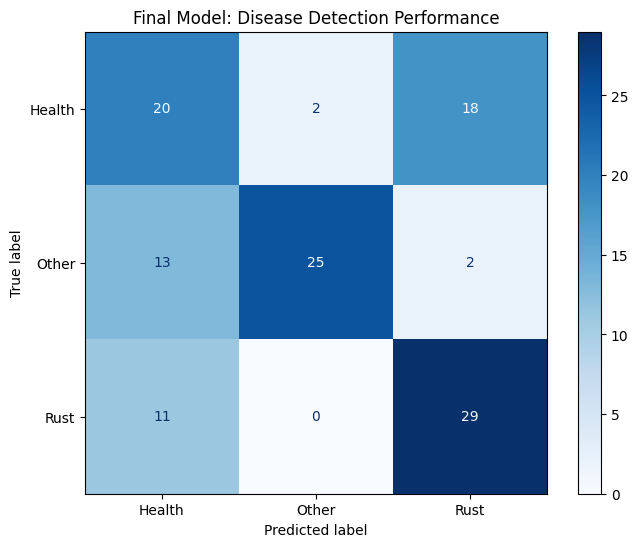

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        rgb, ms, hs = batch['rgb'].to(device), batch['ms'].to(device), batch['hs'].to(device)
        outputs = model(rgb, ms, hs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(batch['label'].numpy())
        y_pred.extend(predicted.cpu().numpy())

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Health', 'Other', 'Rust'])
disp.plot(cmap='Blues', ax=ax)
plt.title("Final Model: Disease Detection Performance")
plt.show()

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


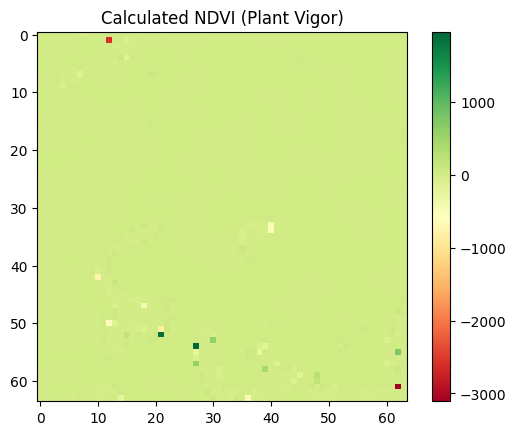

In [21]:
import matplotlib.pyplot as plt

sample = train_ds[0]
ndvi_sample = sample['ms'][5].numpy()

plt.imshow(ndvi_sample, cmap='RdYlGn')
plt.title("Calculated NDVI (Plant Vigor)")
plt.colorbar()
plt.show()